# Topic 3: Bonus - Optimizing Portfolios with QAOA

Based on example from https://qiskit-community.github.io/qiskit-finance/tutorials/01_portfolio_optimization.html

## Table of contents

1. Introduction
   - Use Case
   - Quantum Solution Theory
2. QUBO Tutorial
   - Imports and setup
   - Create and plot the data
   - Classical Solution
   - Quantum Solution
   - Classical Constrained Solution
   - Quantum Constrained Solution
3. Exercise

## 1. Introduction

Here we given an example of how the QAOA algorithm can be used to solve financial portfolio optimization problems.

### 1.1 Use Case

We are given a set of $n$ assets $\{1, 2, ..., n\}$, each with an expected return $\mu_i$.
In this simplified model, we have a binary choice: either choose an asset of do not.
We wish to find the maximum return:
$$ \max_{x_i} \left( \sum_i \mu_i x_i \right) = \min_{x_i} \left( - \sum_i \mu_i x_i \right)$$
where $x_i \in \{0, 1\}$ indicates a decision:
- $x_i=1$ pick asset $i$
- $x_i=0$ don't pick asset $i$

However we also want to take risk into account, which can be done via the covariances between the assets $\sigma_{ij}$.
Thus we want to minimize the following cost function:
$$C(\{x_i\}) = - \sum_i \mu_i x_i  + q\sum_{ij} \sigma_{ij} x_i x_j$$
where $q$ is the risk factor. 

To understand this cost function note that:
- For $q=0$ we just pick the best assests based on expected return
- For $q>0$ we take volatility into account
- For $q >>0$ we pick the assets with low variance and negative covariance

If $p_i^{(t)}$ is the price at time $t$ for asset $i$ then the return on investiment (ROI) at time $t$ is 
$\left(p_i^{(t+1)} - p_i^{(t)} \right) / p_i^{(t)} $. To compute $\mu_i$ we calculate the mean ROI over the whole period and to compute $\sigma_{ij}$ we calculate the covariance between difference the ROIs of different assets over the whole period.

For more on the portfolio model see [here](https://en.wikipedia.org/wiki/Modern_portfolio_theory).

### 1.2 Quantum Solution Theory

To Solve on a QC, we change to $x_i=(1-z_i)/2$
$$
\begin{split}
C(\{z_i\}) &= \frac{1}{2} \sum_i (\mu_i z_i-\mu_i) + \frac{q}{4}\sum_{ij} (\sigma_{ij} - \sigma_{ij} z_j  - \sigma_{ij} z_i + \sigma_{ij} z_i z_j) \\
&= \text{const} + \frac{1}{4}\left(\sum_i  c_i z_i + q\sum_{i \ne j} \sigma_{ij} z_i z_j \right) \\
\end{split}
$$
Now we have the Quantum Hamiltonian:
$$H = \sum_i  c_i Z_i + q\sum_{i \ne j} \sigma_{ij} Z_i Z_j $$
where $c_i=2\mu - q\sum_j(\sigma_{ij} + \sigma_{ji})$.

Given an ansatz $|\psi(\theta)\rangle$ we minimize $\langle \psi(\theta)|H|\psi(\theta)\rangle$ to find our solution.


Suppose we have a budget $B \in N$ we must spend, i.e.
$$\sum_i x_i = B$$

We can force our quantum algorithm to find such solution by introducing a penalty term in the cost function
$$
C_{\text{penalty}} = \lambda \left(\sum_i x_i - B\right)^2
$$

Thus our Hamiltonian is now
$$H = \sum_i  \left(c_i - \lambda \tilde n \right) Z_i + \sum_{i \ne j} \left(q\sigma_{ij}  + \frac{\lambda}{4} \right) Z_i Z_j  $$
where $\tilde n = \frac{n - 2B}{2}.$


### 2. QUBO tutorial

### 2.1 Imports and setup

In [19]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit.library import QAOAAnsatz
from qiskit_finance.data_providers import RandomDataProvider
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp

from scipy.optimize import minimize

from datetime import datetime

%matplotlib inline

### 2.2 Create and plot the data

In [20]:
num_assets = 4
q = 2.0  # Set the risk factor

# We use randomly generated data using `RandomDataProvider`.
# The number of assets `num_assets` will equal the number of qubits required in the quantum computation.

stocks = [("Company %i" % i) for i in range(1, 1+num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime(2016, 1, 1),
    end=datetime(2016, 3, 1),
    seed=4,
)
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

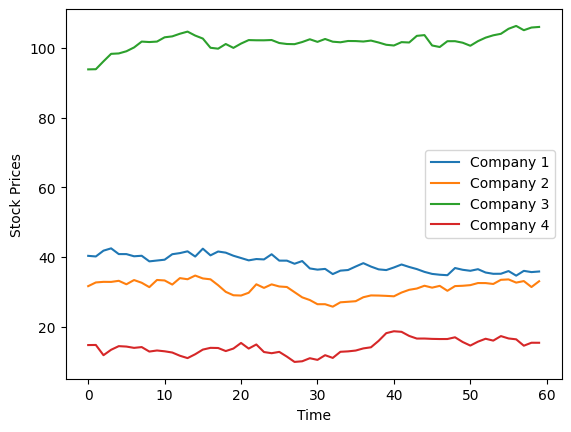

In [21]:
# Plot the stock prices
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.ylabel("Stock Prices")
plt.xlabel("Time")
plt.show()

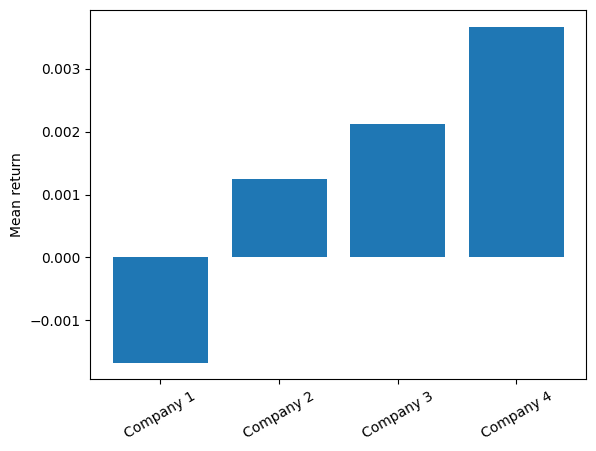

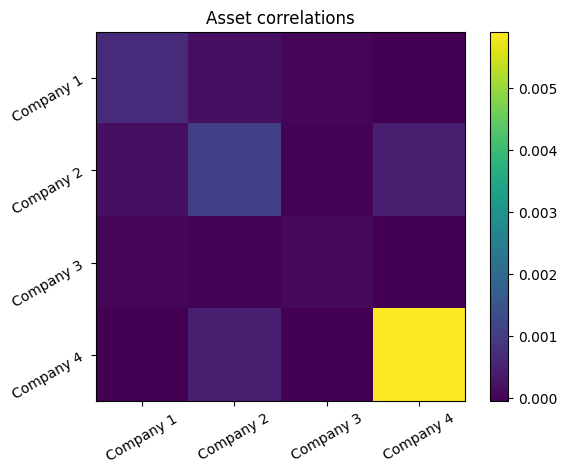

In [22]:
# Visualize mu and sigma
plt.figure()
plt.bar(range(num_assets), mu)
plt.xticks(range(num_assets), stocks, rotation=30)
plt.ylabel('Mean return')

plt.figure()
plt.imshow(sigma)
plt.xticks(range(num_assets), stocks, rotation=30)
plt.yticks(range(num_assets), stocks, rotation=30)
plt.title('Asset correlations')
plt.colorbar()
plt.show()

### 2.3 Classical Solution
Here we minimize the cost function by seacrhing through all the combinations of $\{x_i\}$. This scales as $2^{n}$.

In [23]:
def cost_func(x):
    return - np.sum(x * mu) + q * np.sum(np.outer(x, x) * sigma)

def bin_string_to_cost(bin_string):
    x = np.array(list(bin_string), dtype=int)
    return cost_func(x)


costs = []

for i in range(2**num_assets):
    bin_i = np.binary_repr(i, num_assets)
    costs.append(bin_string_to_cost(bin_i))
    print(f"Assets: {bin_i} Cost: {costs[-1]}")

best_assets = np.binary_repr(np.argmin(costs), num_assets)

print(f"\nBest solution: {best_assets} Cost: {min(costs)}")

Assets: 0000 Cost: 0.0
Assets: 0001 Cost: 0.008143299227542165
Assets: 0010 Cost: -0.0019186308869916574
Assets: 0011 Cost: 0.005983352606769094
Assets: 0100 Cost: 0.0008584136138378232
Assets: 0101 Cost: 0.0107490894583868
Assets: 0110 Cost: -0.0010421601657363694
Assets: 0111 Cost: 0.008607199945031193
Assets: 1000 Cost: 0.002998301588287641
Assets: 1001 Cost: 0.010921724815000828
Assets: 1010 Cost: 0.0012762996749757511
Assets: 1011 Cost: 0.008958407167907525
Assets: 1100 Cost: 0.0045824863252258265
Assets: 1101 Cost: 0.014253286168945827
Assets: 1110 Cost: 0.0028785415193314005
Assets: 1111 Cost: 0.012308025629269987

Best solution: 0010 Cost: -0.0019186308869916574


### 2.4 Quantum Solution

In [24]:
def construct_hamiltonian(single_coefs, double_coefs):
    """Builds the quantum hamiltonian operator"""
    operators = []
    coefs = []

    for i in range(num_assets):
        op = ['I'] * num_assets
        op[i] = 'Z'
        operators.append(Pauli(''.join(op)))
        coefs.append(single_coefs[i])
        
    for i in range(num_assets-1):
        for j in range(i+1, num_assets):
            op = ['I'] * num_assets
            op[i] = 'Z'
            op[j] = 'Z'
            operators.append(Pauli(''.join(op)))
            coefs.append(double_coefs[i, j] + double_coefs[j, i])

    return SparsePauliOp(operators, coefs)

In [25]:
c = 2*mu - q*sigma.sum(0) - q*sigma.sum(1)
hamiltonian = construct_hamiltonian(c, q * sigma)
hamiltonian

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[-6.69912727e-03+0.j, -4.20803208e-03+0.j,  3.86389143e-03+0.j,
 -1.75727833e-02+0.j,  7.25771123e-04+0.j,  1.96628974e-04+0.j,
 -2.19876001e-04+0.j,  1.80571074e-05+0.j,  1.74737662e-03+0.j,
 -2.41315734e-04+0.j])

In [26]:
# Check the eigenvalues of the Hamiltonian matches the classical solutions.
const = - 0.5 * mu.sum() + q * 0.25 * (sigma.sum() + sigma.trace())
assert np.allclose(const + 0.25*np.diag(hamiltonian.to_matrix()), costs)

In [27]:
def compute_energy(params, ansatz, cost_history, estimator):
    """Return estimate of energy from estimator"""
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history.append(energy)
    return energy

def run_optimization(ansatz, intial_parameters):
    """
    Minimize the energy of a given ansatz. 
    Return the cost history and the probabilities of the final state.
    """
    estimator = StatevectorEstimator()
    cost_history = []
    results = minimize(
        compute_energy, 
        intial_parameters, 
        method="BFGS", 
        args=(ansatz, cost_history, estimator)
        )

    print(results)

    state_vector =  Statevector(ansatz.assign_parameters(results.x))
    return state_vector.probabilities(), cost_history


def view_results(probabilities, cost_history):
    plt.figure()
    plt.plot(cost_history)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")

    xs = range(len(probabilities))
    plt.figure()
    plt.bar(xs, probabilities)
    plt.axvline(x=int(best_assets, 2), c='k', ls='dashed', label='Classical Sol.')
    plt.xticks(xs, [np.binary_repr(i, num_assets) for i in xs], rotation=30)
    plt.legend()
    plt.xlabel("Solution")
    plt.ylabel("Probability")

    plt.show()

In [28]:
estimator = StatevectorEstimator()

reps = 3
ansatz = QAOAAnsatz(cost_operator=hamiltonian, reps=reps)

probabilities, cost_history = run_optimization(ansatz, 2. * np.pi * np.random.rand(2*reps))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.02942867961022252
        x: [ 4.036e+00  3.512e+00 -1.271e+00  4.175e+01  9.327e+01
             9.111e+01]
      nit: 84
      jac: [ 3.092e-07  2.640e-07  4.268e-07  1.956e-08  5.240e-06
            -5.390e-06]
 hess_inv: [[ 2.452e+01  8.608e+00 ...  9.182e+02  8.942e+02]
            [ 8.608e+00  1.537e+01 ... -5.903e-01 -9.701e-01]
            ...
            [ 9.182e+02 -5.903e-01 ...  1.484e+05  1.445e+05]
            [ 8.942e+02 -9.701e-01 ...  1.445e+05  1.406e+05]]
     nfev: 707
     njev: 101


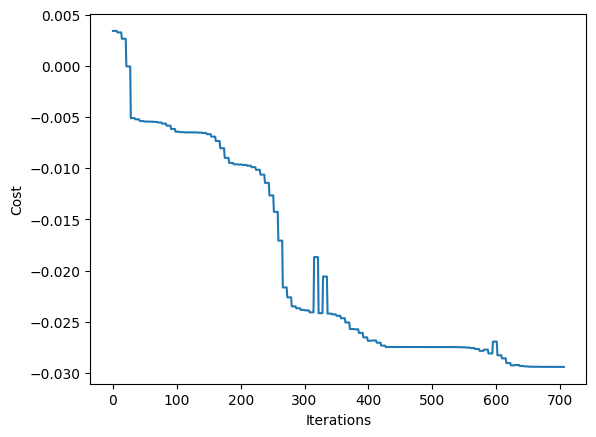

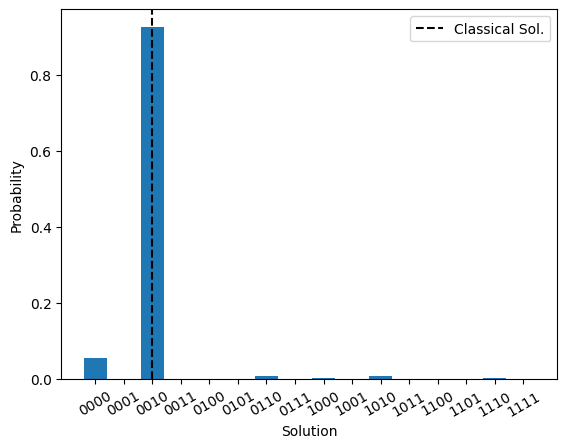

In [29]:
view_results(probabilities, cost_history)

### 2.5 Classical Constrained Solution
Now we add a constraint, we want to purchase a certain number of the assets (our budget).

In [30]:
budget = 2

In [31]:
costs = []
budget_solutions = []

for i in range(2**num_assets):
    bin_i = np.binary_repr(i, num_assets)
    if bin_i.count('1') == budget:
        costs.append(bin_string_to_cost(bin_i))
        budget_solutions.append(bin_i)
        print(f"Assets: {bin_i} Cost: {costs[-1]}")

best_assets = budget_solutions[np.argmin(costs)]
print(f"\nBest solution: {best_assets} Cost: {costs[np.argmin(costs)]}")

Assets: 0011 Cost: 0.005983352606769094
Assets: 0101 Cost: 0.0107490894583868
Assets: 0110 Cost: -0.0010421601657363694
Assets: 1001 Cost: 0.010921724815000828
Assets: 1010 Cost: 0.0012762996749757511
Assets: 1100 Cost: 0.0045824863252258265

Best solution: 0110 Cost: -0.0010421601657363694


### 2.6 Quantum Constrained Solution

In [32]:
n_tidle = (num_assets - 2*budget) / 2.

lambda_param = 0.01

hamiltonian = construct_hamiltonian(c - lambda_param*n_tidle, q * sigma + lambda_param / 4.)
hamiltonian

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[-0.00669913+0.j, -0.00420803+0.j,  0.00386389+0.j, -0.01757278+0.j,
  0.00572577+0.j,  0.00519663+0.j,  0.00478012+0.j,  0.00501806+0.j,
  0.00674738+0.j,  0.00475868+0.j])

In [33]:
reps = 3
ansatz = QAOAAnsatz(cost_operator=hamiltonian, reps=reps)

probabilities, cost_history = run_optimization(ansatz, 2. * np.pi * np.random.rand(2*reps))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.029807691645715437
        x: [ 5.589e+00  5.760e+00  2.925e+00  2.174e+01  4.005e+01
             5.741e+01]
      nit: 86
      jac: [-7.036e-06 -1.908e-06 -2.864e-06  3.539e-08 -7.055e-08
            -1.513e-08]
 hess_inv: [[ 1.216e+01  3.006e+00 ... -2.652e+02 -1.115e+03]
            [ 3.006e+00  1.049e+01 ... -8.524e+01 -6.004e+02]
            ...
            [-2.652e+02 -8.524e+01 ...  6.276e+04  6.304e+04]
            [-1.115e+03 -6.004e+02 ...  6.304e+04  2.813e+05]]
     nfev: 700
     njev: 100


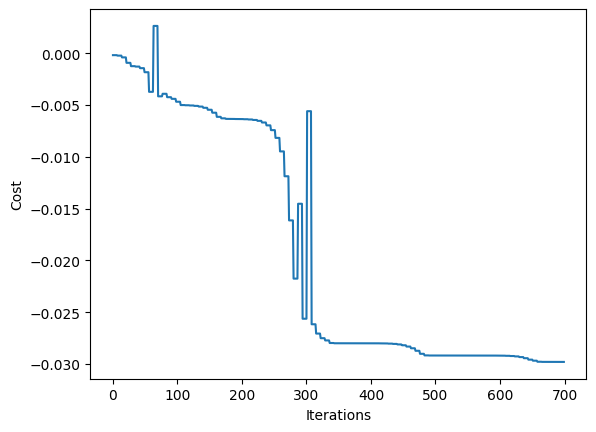

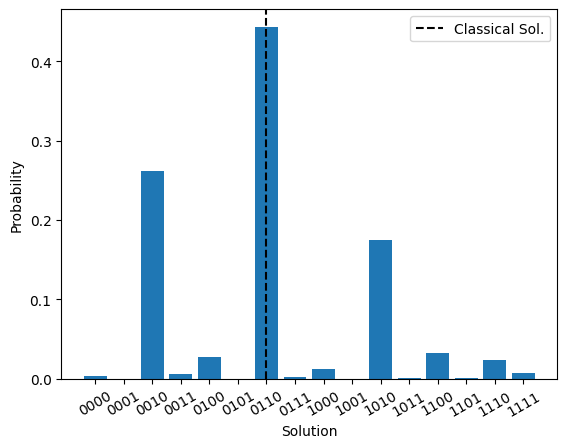

In [34]:
view_results(probabilities, cost_history)

## 3. Excercise

### 3.1 Improved performance on constrained problem
Try to see if you can achieve better results for the constrained case by varying: 
- the number of repitions of the ansatz: `nreps`  
- the budget penalty term: `lambda_param`
- the choice of optimizer (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for the possible choices of method)

### 3.2 More Assets
How does the QAOA algorithm perform when there are 5 assets?

## Acknowledgements

We extend our gratitude to the Irish Centre for High-End Computing (ICHEC) and University of Galway for providing computing and for all-encompassing invaluable support. This project was funded by the EuroHPC JU under grant agreement No 951732 and Ireland.

<div>
  <img src="../logos/ICHEC.png" height="100" style="display: inline-block; margin-right: 15px;">
  <img src="../logos/UoG_.png" height="100" style="display: inline-block; margin-right: 15px;">
  <img src="../logos/EuroCC-Ireland.png" height="100" style="display: inline-block; margin-right: 15px;">
  <img src="../logos/EU-flag-Horizon-Europe.jpg" height="100" style="display: inline-block;">
</div>